Import Libraries

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


Load Dataset

In [44]:
# Load the dataset (Make sure the CSV file is in the same directory as the Jupyter notebook)
df = pd.read_csv("labeled_student_data_s.csv")
df.head()  # Display the first 5 rows

,Student ID,Operating System,DSA,Frontend,Backend,Machine Learning,Data Analytics,Project 1,Project 2,Project 3,Project 4,Interest Label
0,1,52,5,6,6,14,93,Cybersecurity,Cybersecurity,Cybersecurity,Robotics,Robotics
1,2,41,65,80,65,75,34,Web Development,AI,Data Science,Game Development,AI
2,3,53,65,100,98,11,55,Robotics,Game Development,Data Science,Machine Learning,Machine Learning
3,4,62,97,97,9,97,91,AI,AI,Cybersecurity,AI,AI
4,5,49,46,76,8,89,28,Robotics,Cybersecurity,Machine Learning,Robotics,Robotics


Define Subject and Project Columns

In [45]:
# Define subject and project columns
subject_cols = ['Operating System', 'DSA', 'Frontend', 'Backend', 'Machine Learning', 'Data Analytics']
project_cols = ['Project 1', 'Project 2', 'Project 3', 'Project 4']

Function to Label Student Interest

In [46]:
import pandas as pd
import numpy as np

# Ensure subject columns are numeric
df[subject_cols] = df[subject_cols].apply(pd.to_numeric, errors='coerce')

# Function to determine the student's interest
def determine_interest(row):
    # Select numeric values only
    top_subjects = row[subject_cols].astype(float).nlargest(3).index.tolist()  # Get top 3 subjects
    projects = row[project_cols].dropna().tolist()  # Get all projects (remove NaNs)
    
    for project in projects:
        if project in top_subjects:
            return project  # Assign domain directly if a project matches a strong subject
    
    return np.random.choice(projects) if projects else "Exploring"  # Handle empty projects

# Apply the function to label the dataset
df['Interest Label'] = df.apply(determine_interest, axis=1)
df.head()

,Student ID,Operating System,DSA,Frontend,Backend,Machine Learning,Data Analytics,Project 1,Project 2,Project 3,Project 4,Interest Label
0,1,52,5,6,6,14,93,Cybersecurity,Cybersecurity,Cybersecurity,Robotics,Cybersecurity
1,2,41,65,80,65,75,34,Web Development,AI,Data Science,Game Development,Game Development
2,3,53,65,100,98,11,55,Robotics,Game Development,Data Science,Machine Learning,Machine Learning
3,4,62,97,97,9,97,91,AI,AI,Cybersecurity,AI,Cybersecurity
4,5,49,46,76,8,89,28,Robotics,Cybersecurity,Machine Learning,Robotics,Machine Learning


Encode Labels

In [47]:
# Encode categorical labels (interest domains)
label_encoder = LabelEncoder()
df['Interest Label Encoded'] = label_encoder.fit_transform(df['Interest Label'])
df[['Interest Label', 'Interest Label Encoded']].head()

,Interest Label,Interest Label Encoded
0,Cybersecurity,1
1,Game Development,3
2,Machine Learning,4
3,Cybersecurity,1
4,Machine Learning,4


Define Features (X) and Target (y)

In [48]:
# Define input features and target
X = df[subject_cols]
y = df['Interest Label Encoded']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Apply SMOTE for Balancing Data

In [49]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
pd.Series(y_train_resampled).value_counts()

Interest Label Encoded
3    953
6    953
4    953
1    953
2    953
5    953
0    953
Name: count, dtype: int64

Feature Scaling

In [50]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

Train XGBoost Model

In [51]:
# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.5, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy After SMOTE:", accuracy_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy After SMOTE: 0.2125

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.20      0.19        89
           1       0.08      0.08      0.08        92
           2       0.13      0.14      0.14        92
           3       0.15      0.16      0.15        99
           4       0.43      0.40      0.42       239
           5       0.11      0.09      0.10        96
           6       0.11      0.12      0.11        93

    accuracy                           0.21       800
   macro avg       0.17      0.17      0.17       800
weighted avg       0.22      0.21      0.21       800



Hyperparameter Tuning (GridSearchCV)

In [52]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Ensure y_train_resampled has more than 2 classes
# num_classes = len(set(y_train_resampled))

# xgb = XGBClassifier(
#     objective="multi:softprob" if num_classes > 2 else "binary:logistic",  # Automatically choose objective
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='mlogloss'  # Log loss for multi-class classification
# )

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=5,
#     n_jobs=-1  # Use all available processors
# )

# # Fit the model
# grid_search.fit(X_train_scaled, y_train_resampled)

# # Best parameters and score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

# # Get the best model and test accuracy
# best_xgb = grid_search.best_estimator_
# y_pred = best_xgb.predict(X_test_scaled)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")


Train Stacking Model

In [53]:
# Stacking model with RandomForest and XGBoost
stack_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

stack_model.fit(X_train_scaled, y_train_resampled)
y_pred_stack = stack_model.predict(X_test_scaled)

# Evaluate Stacking Model
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

Stacking Model Accuracy: 0.2275

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.17      0.17        89
           1       0.11      0.09      0.10        92
           2       0.10      0.10      0.10        92
           3       0.10      0.08      0.09        99
           4       0.38      0.52      0.44       239
           5       0.10      0.06      0.08        96
           6       0.15      0.12      0.13        93

    accuracy                           0.23       800
   macro avg       0.16      0.16      0.16       800
weighted avg       0.20      0.23      0.21       800



Voting Classifier

In [54]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
svc = SVC(kernel='rbf', probability=True)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('svc', svc)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train_resampled)
print("Voting Classifier Accuracy:", voting_clf.score(X_test_scaled, y_test))

Voting Classifier Accuracy: 0.22125


Check Class Distribution After SMOTE

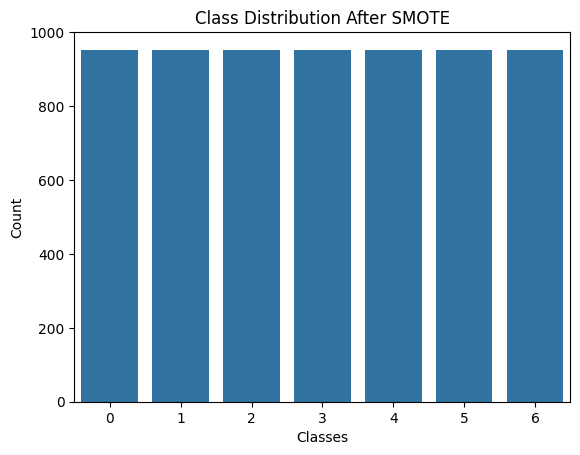

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

Check Feature Importance

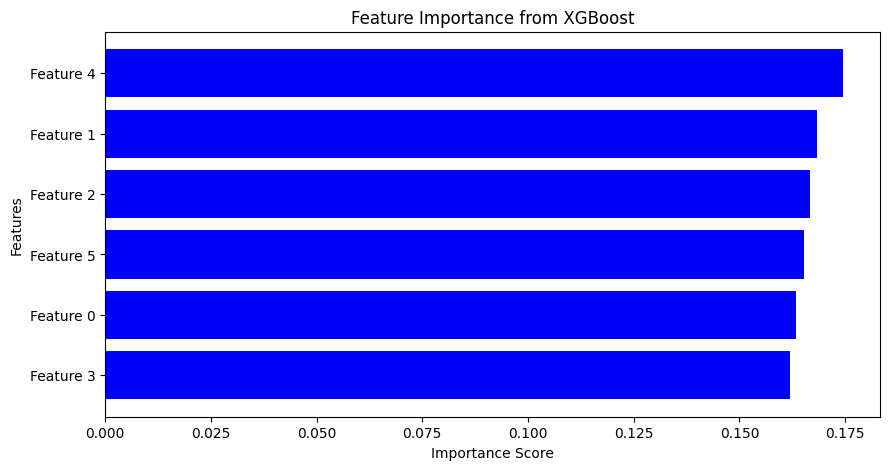

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Train a basic XGBoost model
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42)
xgb_model.fit(X_train_scaled, y_train_resampled)

# Get feature importance
feature_importance = xgb_model.feature_importances_

# Create feature names dynamically
feature_names = [f"Feature {i}" for i in range(X_train_scaled.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

Feature Engineering (Check Correlation)

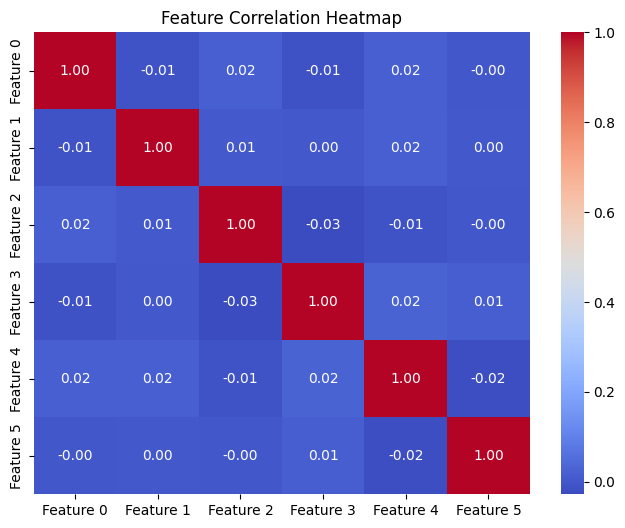

In [57]:
import seaborn as sns

# Convert to DataFrame (if needed)
X_train_df = pd.DataFrame(X_train_scaled, columns=[f"Feature {i}" for i in range(X_train_scaled.shape[1])])

# Plot correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(X_train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Feature Selection (Try Removing Features)

In [58]:
X_train_selected = np.delete(X_train_scaled, [3], axis=1)  # Removing Feature 3
X_test_selected = np.delete(X_test_scaled, [3], axis=1)

xgb_model.fit(X_train_selected, y_train_resampled)
y_pred_selected = xgb_model.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy after feature removal: {accuracy_selected}")


Accuracy after feature removal: 0.1975


Try a Different Model (LightGBM)

In [59]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective="multiclass", random_state=42)
lgb.fit(X_train_scaled, y_train_resampled)

y_pred_lgb = lgb.predict(X_test_scaled)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy: {accuracy_lgb}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 6671, number of used features: 6
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
LightGBM Accuracy: 0.22
